# Forecast a multivariate time series

with TensorFlow 2.0

dataset: Brugge field .mat

## What to implement

각 well마다 104개의 모델이 있다. 이 중에서 80개는 training set으로 나머지는 validation set으로 사용한다.

LSTM은 Input sequence 5개 `(t-5)~(t-1)`, Output sequence 1개`t`로 되어있다. Layer 구성은 2개의 LSTM layer, 2개의 dropout layer, 1개의 Dense layer로 한다. 

Inference시에 
- 먼저 day 1004까지(index 앞의 150개)는 그대로 넣어 predict한다.
- 그 다음부터는 이전 5개의 값으로 t에서의 value를 예측한다.
- 가장 과거의 값(t-5)은 잊어버리고 예측한 값을 window에 넣어준다.
- window 안에 있는 새로운 5개 timestep의 value들의 mean을 구한다.
- 구한 mean과 일정한 std 값으로 Gaussian noise가 들어간 값으로 predict 한 값을 replace한다.
- 즉 window의 가장 최근 값은, predict한 값이 아니라, predict_val + gaussian_noise(window_mean, std)가 들어가게 된다.
- 이 window를 가지고 다음 t에서의 value를 예측한다.

## Setup

In [1]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

DATA_PATH = '../data'
DATA_FILE_NAME = 'Brugge_en_d.mat'
RESULT_FILE_NAME = 'rmse_brugge.csv'

TRAIN_SPLIT = 150
BUFFER_SIZE = 1000
BATCH_SIZE = 32
EVALUATION_INTERVAL = 10
EPOCHS = 200

data_dir = pjoin(DATA_PATH, DATA_FILE_NAME)
mat_contents = sio.loadmat(data_dir)

data = mat_contents['en_d'][0, 0]

# tf.debugging.set_log_device_placement(True)

## Data Preparation

In [9]:
well_dic = {}

for well_index in range(20): # well, Producer P1-P20
    # 'model_num' => dataframe
    model_dic = {}
    well_key = 'P' + str(well_index+1)
    for model_index in range(104): # model, model 1-104
        well_data = np.array([
            data['WOPR'][0,0][well_key][:,model_index],
            data['WBHP'][0,0][well_key][:,model_index],
            data['WWCT'][0,0][well_key][:,model_index],
            data['WWPR'][0,0][well_key][:,model_index]
          ])
        # col1: WOPR, col2: WBHP, col3: WWCT, col4: WWPR
        # row1: day1, ... row 498: day3648
        well_data = well_data.T
        df = pd.DataFrame(
            data=well_data,
            columns=['WOPR', 'WBHP', 'WWCT', 'WWPR']
        )
        model_dic[str(model_index+1)] = df
        
    well_dic[str(well_index+1)] = model_dic

In [3]:
def plot_single_well(well_dic, well_num):
    ax = plt.gca()
    true_model_num = 103
    for i in range(104):
        df = well_dic[str(well_num)][str(i+1)]
        if i == true_model_num:
            df.plot(y='WOPR', ax=ax, color='red', legend=False)
        else:
            df.plot(y='WOPR', ax=ax, color='gray', legend=False)
            
    plt.show()

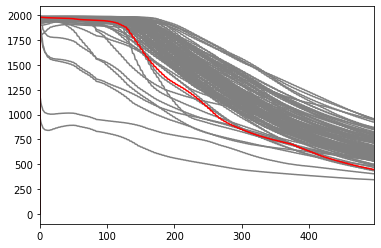

In [4]:
plot_single_well(well_dic, 5)

# Data Preprocessing

In [10]:
well5 = well_dic['5']

In [11]:
well5

{'1':           WOPR      WBHP      WWCT        WWPR
 0       0.0000  2348.024  0.000000     0.00000
 1    1963.8990  2104.888  0.017938    35.87136
 2    1962.6620  2091.095  0.018556    37.10804
 3    1962.5230  2085.370  0.018626    37.24699
 4    1962.4710  2081.623  0.018652    37.29886
 ..         ...       ...       ...         ...
 493   667.0668  1620.034  0.666428  1332.70300
 494   663.4497  1621.595  0.668237  1336.32000
 495   663.2374  1621.689  0.668343  1336.53300
 496   662.5985  1621.971  0.668663  1337.17200
 497   661.1443  1622.610  0.669390  1338.62600
 
 [498 rows x 4 columns],
 '2':           WOPR      WBHP      WWCT        WWPR
 0       0.0000  2348.024  0.000000     0.00000
 1    1965.8180  2112.470  0.016978    33.95207
 2    1964.7620  2094.501  0.017506    35.00818
 3    1964.3870  2085.010  0.017694    35.38297
 4    1964.2000  2078.896  0.017787    35.56979
 ..         ...       ...       ...         ...
 493   630.8185  1611.666  0.684555  1368.95200
 49

In [12]:
# Todo 
# delte rows where WOPR is zero
def remove_zero_wopr(well):
    for model_index in well:
        df = well5[model_index]
        well5[model_index] = df[df.WOPR != 0]

In [13]:
remove_zero_wopr(well5)

In [14]:
well5

{'1':           WOPR      WBHP      WWCT        WWPR
 1    1963.8990  2104.888  0.017938    35.87136
 2    1962.6620  2091.095  0.018556    37.10804
 3    1962.5230  2085.370  0.018626    37.24699
 4    1962.4710  2081.623  0.018652    37.29886
 5    1962.6600  2076.356  0.018557    37.11052
 ..         ...       ...       ...         ...
 493   667.0668  1620.034  0.666428  1332.70300
 494   663.4497  1621.595  0.668237  1336.32000
 495   663.2374  1621.689  0.668343  1336.53300
 496   662.5985  1621.971  0.668663  1337.17200
 497   661.1443  1622.610  0.669390  1338.62600
 
 [497 rows x 4 columns],
 '2':           WOPR      WBHP      WWCT        WWPR
 1    1965.8180  2112.470  0.016978    33.95207
 2    1964.7620  2094.501  0.017506    35.00818
 3    1964.3870  2085.010  0.017694    35.38297
 4    1964.2000  2078.896  0.017787    35.56979
 5    1964.0530  2069.641  0.017861    35.71712
 ..         ...       ...       ...         ...
 493   630.8185  1611.666  0.684555  1368.95200
 49

In [15]:
def serialize_well_dataframe(well):
    serialized_well = np.empty((0, 4))
    end_indice = []
    for model in well:
        dataset = well[str(model)].values
        serialized_well = np.concatenate((serialized_well, dataset))
        num_timesteps = dataset.shape[0]
        if len(end_indice) == 0:
            end_indice.append(num_timesteps)
        else:
            end_indice.append(num_timesteps + end_indice[-1])
    return serialized_well, end_indice

In [16]:
serialized_dataset, end_indice = serialize_well_dataframe(well5)

In [17]:
serialized_dataset.shape

(51688, 4)

In [18]:
serialized_dataset[:end_indice[0]]

array([[1.963899e+03, 2.104888e+03, 1.793800e-02, 3.587136e+01],
       [1.962662e+03, 2.091095e+03, 1.855600e-02, 3.710804e+01],
       [1.962523e+03, 2.085370e+03, 1.862600e-02, 3.724699e+01],
       ...,
       [6.632374e+02, 1.621689e+03, 6.683430e-01, 1.336533e+03],
       [6.625985e+02, 1.621971e+03, 6.686630e-01, 1.337172e+03],
       [6.611443e+02, 1.622610e+03, 6.693900e-01, 1.338626e+03]])

In [19]:
serialized_dataset[end_indice[102]:end_indice[103]]

array([[1.980531e+03, 1.474149e+03, 9.621000e-03, 1.923936e+01],
       [1.978874e+03, 1.353765e+03, 1.044900e-02, 2.089570e+01],
       [1.978090e+03, 1.280798e+03, 1.084100e-02, 2.168011e+01],
       ...,
       [4.480789e+02, 3.795724e+02, 7.759350e-01, 1.551691e+03],
       [4.475254e+02, 3.805829e+02, 7.762120e-01, 1.552245e+03],
       [4.462617e+02, 3.828381e+02, 7.768430e-01, 1.553508e+03]])

In [34]:
from sklearn.preprocessing import MinMaxScaler

def scale_model_separately(serialized_dataset, end_indice):
    scaler_min = []
    scaler_scale = []
    scaled_dataset = np.empty((0, 4))

    for i in range(len(end_indice)):
        scaler = MinMaxScaler()
        start_index = end_indice[i-1] if i > 0 else 0
        end_index = end_indice[i]
        print(f"scaling from {start_index} to {end_index-1}")
    
        scaler.fit(serialized_dataset[start_index:end_index])
        print(f"scaler_min: {scaler.min_[0]}, scaler_scale: {scaler.scale_[0]}")
        
        transformed = scaler.transform(serialized_dataset[start_index:end_index])
        scaled_dataset = np.concatenate((scaled_dataset, transformed))
        scaler_min.append(scaler.min_[0])
        scaler_scale.append(scaler.scale_[0])
        
    return scaled_dataset, scaler_min, scaler_scale

In [43]:
scaled_dataset, scaler_min, scaler_scale = scale_model_separately(serialized_dataset, end_indice)

scaling from 0 to 496
scaler_min: -0.5045036389970825, scaler_scale: 0.0007630764403430272
scaling from 497 to 993
scaler_min: -0.4668394830787743, scaler_scale: 0.0007460989470454781
scaling from 994 to 1490
scaler_min: -0.4650324374703558, scaler_scale: 0.0007442432597795237
scaling from 1491 to 1987
scaler_min: -0.6218477615492927, scaler_scale: 0.0008241900437183367
scaling from 1988 to 2484
scaler_min: -0.4827782539148586, scaler_scale: 0.0007598605777417535
scaling from 2485 to 2981
scaler_min: -0.5142717946198585, scaler_scale: 0.0007712336630537198
scaling from 2982 to 3478
scaler_min: -0.49538825245311446, scaler_scale: 0.0007633005696741142
scaling from 3479 to 3975
scaler_min: -0.45284036965853675, scaler_scale: 0.0007467366488340977
scaling from 3976 to 4472
scaler_min: -0.5035751067253896, scaler_scale: 0.0007638382474739679
scaling from 4473 to 4969
scaler_min: -0.37153138607865477, scaler_scale: 0.0007002632429582929
scaling from 4970 to 5466
scaler_min: -0.3967557608547

In [44]:
scaled_dataset[:end_indice[0]]

array([[0.99410142, 1.        , 0.00589943, 0.00589899],
       [0.99315749, 0.97701328, 0.00684248, 0.00684267],
       [0.99305143, 0.96747228, 0.0069493 , 0.0069487 ],
       ...,
       [0.0015972 , 0.1947247 , 0.9984023 , 0.99840288],
       [0.00110967, 0.19519467, 0.99889061, 0.99889049],
       [0.        , 0.1962596 , 1.        , 1.        ]])

In [45]:
scaled_dataset[:end_indice[0]].shape

(497, 4)

In [46]:
scaled_dataset[end_indice[102]:end_indice[103]]

array([[1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.98920007e-01, 9.17514076e-01, 1.07921827e-03, 1.07956322e-03],
       [9.98409015e-01, 8.67517810e-01, 1.59015252e-03, 1.59082310e-03],
       ...,
       [1.18440746e-03, 2.50006955e-01, 9.98816509e-01, 9.98815722e-01],
       [8.23649408e-04, 2.50699339e-01, 9.99177552e-01, 9.99176806e-01],
       [0.00000000e+00, 2.52244580e-01, 1.00000000e+00, 1.00000000e+00]])

In [47]:
scaled_dataset[end_indice[0]:end_indice[1]].shape

(497, 4)

In [48]:
len(scaler_min), len(scaler_scale)

(104, 104)

In [51]:
end_indice

[497,
 994,
 1491,
 1988,
 2485,
 2982,
 3479,
 3976,
 4473,
 4970,
 5467,
 5964,
 6461,
 6958,
 7455,
 7952,
 8449,
 8946,
 9443,
 9940,
 10437,
 10934,
 11431,
 11928,
 12425,
 12922,
 13419,
 13916,
 14413,
 14910,
 15407,
 15904,
 16401,
 16898,
 17395,
 17892,
 18389,
 18886,
 19383,
 19880,
 20377,
 20874,
 21371,
 21868,
 22365,
 22862,
 23359,
 23856,
 24353,
 24850,
 25347,
 25844,
 26341,
 26838,
 27335,
 27832,
 28329,
 28826,
 29323,
 29820,
 30317,
 30814,
 31311,
 31808,
 32305,
 32802,
 33299,
 33796,
 34293,
 34790,
 35287,
 35784,
 36281,
 36778,
 37275,
 37772,
 38269,
 38766,
 39263,
 39760,
 40257,
 40754,
 41251,
 41748,
 42245,
 42742,
 43239,
 43736,
 44233,
 44730,
 45227,
 45724,
 46221,
 46718,
 47215,
 47712,
 48209,
 48706,
 49203,
 49700,
 50197,
 50694,
 51191,
 51688]

In [49]:
# Todo
# Make multivariate dataset
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
#     print(indices)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [69]:
import random
random.seed(2)

serialized_train_x = np.empty((0, 5, 2))
serialized_train_y = np.empty((0))

past_history = 5
future_target = 0
STEP = 1

# train_split = 80
# num_models = 104
# model_list = list(range(1, num_models+1))

def choose_training_set(scaled_dataset, end_indice):
    training_set = np.empty((0, 4))
    train_end_indice = []
    num_models = 104
    model_list = list(range(1, num_models+1))
    train_set_size = 80
    count = 0
    while (count <= train_set_size): 
        chosen_model = random.choice(model_list)
        print(f"chosen model: {chosen_model}")
        if (chosen_model != 1) :
            start_index = end_indice[chosen_model-2]
            end_index = end_indice[chosen_model-1]
        else:
            start_index = 0;
            end_index = end_indice[chosen_model-1]
        training_set = np.concatenate((training_set, scaled_dataset[start_index: end_index]))
        if (count == 0):
            train_end_indice.append(end_index - start_index)
        else :
            train_end_indice.append(train_end_indice[count-1] + (end_index - start_index))
        count += 1
    return training_set, train_end_indice

In [70]:
training_set, train_end_indice = choose_training_set(scaled_dataset, end_indice)

chosen model: 8
chosen model: 12
chosen model: 11
chosen model: 47
chosen model: 22
chosen model: 95
chosen model: 104
chosen model: 86
chosen model: 40
chosen model: 33
chosen model: 78
chosen model: 28
chosen model: 78
chosen model: 5
chosen model: 75
chosen model: 88
chosen model: 21
chosen model: 56
chosen model: 82
chosen model: 51
chosen model: 103
chosen model: 93
chosen model: 66
chosen model: 48
chosen model: 70
chosen model: 57
chosen model: 65
chosen model: 35
chosen model: 5
chosen model: 4
chosen model: 47
chosen model: 60
chosen model: 41
chosen model: 49
chosen model: 55
chosen model: 68
chosen model: 22
chosen model: 72
chosen model: 23
chosen model: 31
chosen model: 30
chosen model: 4
chosen model: 23
chosen model: 42
chosen model: 23
chosen model: 18
chosen model: 66
chosen model: 66
chosen model: 47
chosen model: 66
chosen model: 87
chosen model: 72
chosen model: 24
chosen model: 58
chosen model: 102
chosen model: 54
chosen model: 95
chosen model: 68
chosen model: 98

In [ ]:
for i in range(train_split):
    start_index = end_indice[i-1] if i > 0 else 0
    end_index = end_indice[i]
    print(f"converting to multivar from {start_index} to {end_index-1}")
    range_multi_x, range_multi_y = multivariate_data(
        serialized_dataset[start_index:end_index][:, :2],
        serialized_dataset[start_index:end_index][:, 0],
        start_index = 0,
        end_index = end_index - start_index,
        history_size = past_history,
        target_size = future_target,
        step = STEP,
        single_step = True
    )
#     print(range_multi_x.shape)
#     print(range_multi_y.shape)
    serialized_train_x = np.concatenate((serialized_train_x, range_multi_x))
    serialized_train_y = np.concatenate((serialized_train_y, range_multi_y))

In [24]:
serialized_train_x.shape, serialized_train_y.shape

((39360, 5, 2), (39360,))

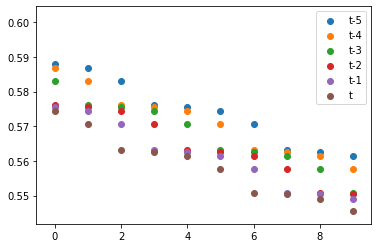

In [25]:
#  validate the data set
plt.figure()

plt.scatter(y=serialized_train_x[250:260, 0, 0], x = range(10), label='t-5')
plt.scatter(y=serialized_train_x[250:260, 1, 0], x = range(10), label='t-4')
plt.scatter(y=serialized_train_x[250:260, 2, 0], x = range(10), label='t-3')
plt.scatter(y=serialized_train_x[250:260, 3, 0], x = range(10), label='t-2')
plt.scatter(y=serialized_train_x[250:260, 4, 0], x = range(10), label='t-1')
plt.scatter(y=serialized_train_y[250:260], x=range(10), label='t')

plt.legend()
plt.show()

In [26]:
serialized_val_x = np.empty((0, 5, 2))
serialized_val_y = np.empty((0))

for i in range(train_split, 103, 1):
    start_index = end_indice[i-1] if i > 0 else 0
    end_index = end_indice[i]
    print(f"converting to multivar from {start_index} to {end_index-1}")
    range_multi_x, range_multi_y = multivariate_data(
        serialized_dataset[start_index:end_index][:, :2],
        serialized_dataset[start_index:end_index][:, 0],
        start_index = 0,
        end_index = end_index - start_index,
        history_size = past_history,
        target_size = future_target,
        step = STEP,
        single_step = True
    )
#     print(range_multi_x.shape)
#     print(range_multi_y.shape)
    serialized_val_x = np.concatenate((serialized_val_x, range_multi_x))
    serialized_val_y = np.concatenate((serialized_val_y, range_multi_y))

converting to multivar from 39760 to 40256
converting to multivar from 40257 to 40753
converting to multivar from 40754 to 41250
converting to multivar from 41251 to 41747
converting to multivar from 41748 to 42244
converting to multivar from 42245 to 42741
converting to multivar from 42742 to 43238
converting to multivar from 43239 to 43735
converting to multivar from 43736 to 44232
converting to multivar from 44233 to 44729
converting to multivar from 44730 to 45226
converting to multivar from 45227 to 45723
converting to multivar from 45724 to 46220
converting to multivar from 46221 to 46717
converting to multivar from 46718 to 47214
converting to multivar from 47215 to 47711
converting to multivar from 47712 to 48208
converting to multivar from 48209 to 48705
converting to multivar from 48706 to 49202
converting to multivar from 49203 to 49699
converting to multivar from 49700 to 50196
converting to multivar from 50197 to 50693
converting to multivar from 50694 to 51190


In [27]:
serialized_val_x.shape, serialized_val_y.shape

((11316, 5, 2), (11316,))

In [28]:
serialized_test_x = np.empty((0, 5, 2))
serialized_test_y = np.empty((0))

for i in range(103, 104):
    start_index = end_indice[i-1] if i > 0 else 0
    end_index = end_indice[i]
    print(f"converting to multivar from {start_index} to {end_index-1}")
    range_multi_x, range_multi_y = multivariate_data(
        serialized_dataset[start_index:end_index][:, :2],
        serialized_dataset[start_index:end_index][:, 0],
        start_index = 0,
        end_index = end_index - start_index,
        history_size = past_history,
        target_size = future_target,
        step = STEP,
        single_step = True
    )
    serialized_test_x = np.concatenate((serialized_test_x, range_multi_x))
    serialized_test_y = np.concatenate((serialized_test_y, range_multi_y))

converting to multivar from 51191 to 51687


In [29]:
serialized_test_x.shape, serialized_test_y.shape

((492, 5, 2), (492,))

In [30]:
train_data = tf.data.Dataset.from_tensor_slices((serialized_train_x, serialized_train_y))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data = train_data.prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((serialized_val_x, serialized_val_y))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [31]:
test_data = tf.data.Dataset.from_tensor_slices((serialized_test_x, serialized_test_y))

# Define model and Train

In [32]:
lstm1_units = 50
lstm2_units = 50
gaussian_std = 0.1
dropout_rate = 0.2

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.GaussianNoise(gaussian_std, input_shape=serialized_train_x.shape[-2:]))

single_step_model.add(tf.keras.layers.LSTM(lstm1_units, activation='relu',return_sequences=True))
single_step_model.add(tf.keras.layers.Dropout(dropout_rate))

single_step_model.add(tf.keras.layers.LSTM(lstm2_units, activation='relu', return_sequences = True))
single_step_model.add(tf.keras.layers.Dropout(dropout_rate))

single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer='adam', loss='mean_squared_error')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

In [33]:
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 5, 2)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 50)             10600     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
dense (Dense)                (None, 5, 1)              51        
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
____________________________________________________

In [34]:
for x, y in val_data.take(1):
  print(single_step_model.predict(x).shape)

(32, 5, 1)


In [35]:
single_step_history = single_step_model.fit(
    train_data,
    epochs=EPOCHS,
    steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE,
    validation_data=val_data,
    validation_steps=50,
    use_multiprocessing=True,
    workers=8,
    callbacks = [es]
)

Train for 4 steps, validate for 50 steps
Epoch 1/200
4/4 [==============================] - 5s 1s/step - loss: 0.3974 - val_loss: 0.4469
Epoch 2/200
4/4 [==============================] - 1s 131ms/step - loss: 0.4785 - val_loss: 0.4109
Epoch 3/200
4/4 [==============================] - 1s 131ms/step - loss: 0.3878 - val_loss: 0.3734
Epoch 4/200
4/4 [==============================] - 0s 124ms/step - loss: 0.2661 - val_loss: 0.3325
Epoch 5/200
4/4 [==============================] - 0s 120ms/step - loss: 0.3004 - val_loss: 0.2849
Epoch 6/200
4/4 [==============================] - 0s 124ms/step - loss: 0.2914 - val_loss: 0.2312
Epoch 7/200
4/4 [==============================] - 1s 126ms/step - loss: 0.2059 - val_loss: 0.1845
Epoch 8/200
4/4 [==============================] - 0s 118ms/step - loss: 0.1445 - val_loss: 0.1717
Epoch 9/200
4/4 [==============================] - 0s 117ms/step - loss: 0.1733 - val_loss: 0.1734
Epoch 10/200
4/4 [==============================] - 1s 131ms/step - los

Epoch 163/200
4/4 [==============================] - 0s 106ms/step - loss: 0.0092 - val_loss: 9.5766e-04
Epoch 164/200
4/4 [==============================] - 0s 108ms/step - loss: 0.0091 - val_loss: 8.9118e-04
Epoch 165/200
4/4 [==============================] - 0s 109ms/step - loss: 0.0094 - val_loss: 6.0704e-04
Epoch 166/200
4/4 [==============================] - 0s 107ms/step - loss: 0.0069 - val_loss: 6.6889e-04
Epoch 167/200
4/4 [==============================] - 0s 111ms/step - loss: 0.0094 - val_loss: 9.5522e-04
Epoch 168/200
4/4 [==============================] - 0s 108ms/step - loss: 0.0096 - val_loss: 9.2964e-04
Epoch 169/200
4/4 [==============================] - 0s 114ms/step - loss: 0.0083 - val_loss: 8.7838e-04
Epoch 170/200
4/4 [==============================] - 0s 119ms/step - loss: 0.0095 - val_loss: 9.1136e-04
Epoch 171/200
4/4 [==============================] - 0s 104ms/step - loss: 0.0085 - val_loss: 0.0010
Epoch 172/200
4/4 [==============================] - 0s 109

In [36]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

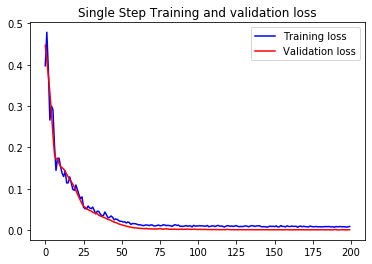

In [37]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Inference

In [134]:
y_hat_list = []
predicted_differences = []

y_hat = single_step_model.predict(serialized_test_x[:150])
y_hat_list = y_hat[:, -1].flatten().tolist()
print(len(y_hat_list))
buffer_test_x = serialized_test_x[150:151]
print(f"before loop {buffer_test_x}, shape {buffer_test_x.shape}")

mu = 0.01
buffer = buffer_test_x

150
before loop [[[0.79066061 0.        ]
  [0.78789578 0.        ]
  [0.77980332 0.        ]
  [0.76427476 0.        ]
  [0.76372205 0.        ]]], shape (1, 5, 2)


In [135]:
for i in range(151, serialized_test_x.shape[0]):
# for i in range(1, 11):
    y_hat = single_step_model.predict(buffer)
#     print(f"y_hat: {y_hat}, shape: {y_hat.shape}")
    predicted_val = y_hat[0, 0, 0]
    y_hat_list.append(predicted_val)
    
    difference = serialized_test_x[i:i+1][0, 4, 0] - predicted_val
    predicted_differences.append(difference)
    
    buffer = np.delete(buffer, 0, 1)
    next_wbhp = serialized_test_x[i:i+1][0, 4, 1]
    predicted_array = np.array([[predicted_val, next_wbhp]])
    
    buffer = np.vstack((buffer[0], predicted_array))
    buffer = np.reshape(buffer, (1, 5, 2))
    
    mean_wopr = np.mean(buffer[0], axis=0)[0]
    mean_wbhp = np.mean(buffer[0], axis=0)[1]
    wopr_predicted_noise_added = np.random.normal(mean_wopr, mu, 1)
    wbhp_predicted_noise_added = np.random.normal(mean_wbhp, mu, 1)
    
    buffer[0, 4, 0] = wopr_predicted_noise_added
    buffer[0, 4, 1] = wbhp_predicted_noise_added
    
#     buffer = np.concatenate((wopr_noise, wbhp_noise), axis = 1)
#     buffer = np.reshape(buffer, (1, 5, 2))
#     print(f"after insertion {buffer}, shape: {buffer.shape}")

491
(492,)


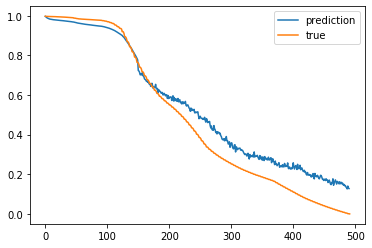

In [136]:
print(len(y_hat_list))
print(serialized_test_y.shape)

plt.plot(y_hat_list, label='prediction')
plt.plot(serialized_test_y, label='true')
# plt.scatter(y=y_hat_list, x = range(len(y_hat_list)), label='prediction')
# plt.scatter(y=serialized_test_y, x = range(len(serialized_test_y)), label='true')

plt.legend()
plt.show()

341


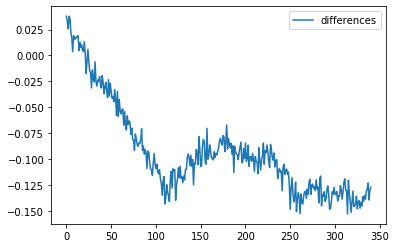

In [137]:
print(len(predicted_differences))
plt.plot(predicted_differences, label = 'differences')
plt.legend()
plt.show()

(492, 1)
(492,)


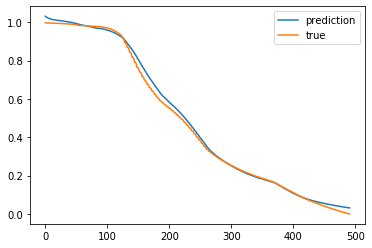

In [113]:
y_hat = single_step_model.predict(serialized_test_x)
# print(y_hat.shape)
print(y_hat[:,-1].shape)
print(serialized_test_y.shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(serialized_test_y, label='true')
# plt.plot(dataset[TRAIN_SPLIT:][:,0], label='from_dataset')
plt.legend()
plt.show()

In [123]:
serialized_test_x[1:2][0]

array([[0.99892001, 0.91751408],
       [0.99840901, 0.86751781],
       [0.99802903, 0.82945619],
       [0.99736096, 0.75984772],
       [0.99716412, 0.7399683 ]])

In [115]:
y_hat

array([[[0.9913136 ],
        [1.0208042 ],
        [1.032735  ],
        [1.0310348 ],
        [1.03152   ]],

       [[0.98176783],
        [1.0145043 ],
        [1.0285252 ],
        [1.0274725 ],
        [1.0295228 ]],

       [[0.97598636],
        [1.010129  ],
        [1.0236322 ],
        [1.0244287 ],
        [1.0270761 ]],

       ...,

       [[0.06280207],
        [0.02901901],
        [0.03232602],
        [0.03557649],
        [0.03196547]],

       [[0.06272262],
        [0.0288747 ],
        [0.03205609],
        [0.03517338],
        [0.03163184]],

       [[0.06248341],
        [0.02844956],
        [0.03144599],
        [0.03472104],
        [0.03125215]]], dtype=float32)

In [ ]:
# Todo
# Temp plotting
# predict from training set
x_entire, _ = multivariate_data(dataset[:, :2], dataset[:, 0], 0,
                                                   None, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

y_hat = single_step_model.predict(x_entire)
# print(y_hat[:,-1].shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(dataset[:, 0], label='true')
plt.legend()
plt.show()

In [ ]:
y_hat = single_step_model.predict(x_val_single)
# print(y_hat.shape)
print(y_hat[:,-1].shape)
print(y_val_single.shape)
# print(y_train_single.shape)
plt.plot(y_hat[:,-1], label='prediction')
plt.plot(y_val_single, label='true')
# plt.plot(dataset[TRAIN_SPLIT:][:,0], label='from_dataset')
plt.legend()
plt.show()

In [ ]:
scaler.min_

In [ ]:
scaler.scale_

In [ ]:
# Evalutate RMSE first and inverse trnasform
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(y_val_single, y_hat[:, -1]))
print('Test RMSE: %.3f' % rmse)

# mse = mean_squared_error(y_val_single, y_hat[:, -1])
# print('Test RMSE: %.3f' % mse)

In [ ]:
# single_feature_inverse = (y_hat[:, -1] - scaler.min_[0])/scaler.scale_[0]

In [ ]:
y_hat_inverse = (y_hat[:, -1] - scaler.min_[0])/scaler.scale_[0]
y_val_inverse = (y_val_single - scaler.min_[0])/scaler.scale_[0]
y_train_inverse = (y_train_single - scaler.min_[0])/scaler.scale_[0]

y_train_inverse = y_train_inverse.reshape((-1, 1))
y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

In [ ]:
plt.plot(y_predicted, linestyle='-', label='prediction')
plt.plot(y_true, linestyle='-', label='true')
plt.xlabel('date')
plt.ylabel('WOPR')
plt.title('WOPR true vs prediction')
plt.legend()
plt.show()

In [ ]:
# Using StandardScaler
# y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_train_inverse = y_train_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

# y_train_inverse = y_train_inverse.reshape((-1, 1))
# y_predicted = np.concatenate((y_train_inverse, y_hat_inverse), axis = None)
# y_true = np.concatenate((y_train_inverse, y_val_inverse.reshape((-1, 1))), axis = None)

# plt.plot(y_predicted, linestyle='-', label='prediction')
# plt.plot(y_true, linestyle='-', label='true')
# plt.xlabel('date')
# plt.ylabel('WOPR')
# plt.title('WOPR true vs prediction')
# plt.legend()
# plt.show()

# Evaluate the model

In [ ]:
# y_hat_inverse = y_hat[:,-1] * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# y_val_inverse = y_val_single * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
# print(y_hat_inverse.shape)
# print(y_val_inverse.reshape((-1, 1)).shape)

In [ ]:
# calculate RMSE
from math import sqrt
from sklearn.metrics import mean_squared_error

# rmse = sqrt(mean_squared_error(y_val_inverse, y_hat_inverse))
# print('Test RMSE: %.3f' % rmse)

mse = mean_squared_error(y_val_inverse, y_hat_inverse)
print('Test RMSE: %.3f' % mse)

In [ ]:
result_dir = pjoin(DATA_PATH, RESULT_FILE_NAME)

with open(result_dir, "a") as f:
    f.write(f"{well_index}, {model_index}, {rmse}, {BATCH_SIZE}, {EPOCHS}, {TRAIN_SPLIT}, {past_history}, {future_target}, {lstm1_units}, {lstm2_units}, {gaussian_std}, {dropout_rate}")
    f.close()

In [ ]:
tf.keras.backend.clear_session()